## Block Number Interpolation

(currently using disambiguous v02)

1. **Sequence Restriction**

This notebook interpolates block numbers by filling in if unknown dwellings are in between known dwellings of the same
    1. block number
    2. block number and distance sequence
    3. block number, distance sequence, and enum_dist
    4. block number, distance sequence, enum_dist, and other sequence

2. **Max Distance Restriction** and **In between number of dwellings**

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da

# Setup

* Read in datasets and set column names

In [2]:
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v02.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_mn_20200918.csv") #For calculating centroids
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_union.csv")

In [3]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"

In [4]:
cd_1850.head()

,OBJECTID,CD_RECORD_ID,CD_INDEX,CD_RAW,CD_OCCUPATION,CD_OCCUPATION_STD,CD_LAST_NAME,CD_FIRST_NAME,CD_MIDDLE_NAME,CD_H_ADDRESS,CD_H_HOUSE_NUMBER,CD_H_STREET_NAME,CD_H_CITY,CD_WARD_NUM,CD_BLOCK_NUM,CD_X,CD_Y
0,1,MN_1850_ADDISON_ACKLEY_1,1,"Ackley Addison, clerk, 47 Broadway, h. 39 Pearl",clerk,clerk,Ackley,Addison,NaN,39 PEARL ST,39,PEARL,NaN,1,mn1850_01_74.0124_40.7034,-74.012269,40.703363
1,3,MN_1850_FREDERICK_ANDERSON_6,6,"Anderson Frederick 11. com. mer. 13 Front, h. ...",com mer,com mer,Anderson,Frederick,11,77 BARROW ST,77,BARROW,NaN,9,mn1850_09_74.0026_40.7323,-74.002268,40.732722
2,4,MN_1850_PETER_ANTHES_8,8,"Anthes Peter, barber 34 Av. C",barber,barbers,Anthes,Peter,NaN,34 C AVE,34,C AVE,NaN,11,mn1850_11_73.9792_40.7214,-73.980422,40.721839
3,5,MN_1850_&_ANTHES_9,9,"Anthes & Eckardt, barbers, 34 Av. C",barbers,barber,Anthes,&,Eckardt,34 C AVE,34,C AVE,NaN,11,mn1850_11_73.9792_40.7214,-73.980422,40.721839
4,6,MN_1850_JOHN_APPELL_10,10,"Appell John, tailor, 40 Av. C",tailor,tailor,Appell,John,NaN,40 C AVE,40,C AVE,NaN,11,mn1850_11_73.9792_40.7214,-73.980322,40.721976


### CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM - CENSUS_ENUMERATOR_NUM - CENSUS_ENUMERATOR_DATE is a minimal key for all wards

* We have previously used only CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM for ward 10, is a minimal key for ward 10 specificaly
* **Need more specificity when merging this into all dwellings. Otherwise, 1 dwelling could be assigned to 2 different enumeration sequences**

In [5]:
print('KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM is a minimal key in')
unique_wards = []
for w in enumerators['CENSUS_WARD_NUM'].unique():
    tempw = enumerators.loc[enumerators['CENSUS_WARD_NUM'] == w]
    if tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM']].shape[0] == tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM']].drop_duplicates().shape[0]:
        print('ward ', w)
        unique_wards.append(w)

KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM is a minimal key in
ward  1
ward  2
ward  3
ward  4
ward  5
ward  6
ward  10
ward  13
ward  14
ward  15
ward  19


In [7]:
print('KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM - CENSUS_ENUMERATOR_NUM is a minimal key in ')
for w in enumerators['CENSUS_WARD_NUM'].unique():
    tempw = enumerators.loc[enumerators['CENSUS_WARD_NUM'] == w]
    if tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM', 'CENSUS_ENUMERATOR_NUM']].shape[0] == tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM', 'CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE']].drop_duplicates().shape[0]:
        print('ward ', w)

KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM - CENSUS_ENUMERATOR_NUM is a minimal key in 
ward  1
ward  2
ward  3
ward  4
ward  5
ward  6
ward  7
ward  8
ward  9
ward  10
ward  11
ward  12
ward  13
ward  14
ward  15
ward  16
ward  17
ward  18
ward  19


## Page number is not unique within wards

* enumerate new page number so that it is unique within a ward

In [33]:

def generate_unique_pagenum(df, page_col):
    temp = df.reset_index()
    start_page = temp.loc[0, page_col]
    end_page = temp.shape[0]
    unique_CENSUS_PAGENNO = range(start_page, start_page+end_page)
    temp[page_col + '_uniquewithinward'] = unique_CENSUS_PAGENNO
    return temp

enumerators2 = enumerators.groupby(['CENSUS_WARD_NUM'], as_index=False).apply(generate_unique_pagenum, 'CENSUS_PAGENNO')

In [34]:
print('KEY: CENSUS_PAGENO - CENSUS_WARD_NUM is a minimal key in')
unique_wards = []
for w in enumerators2['CENSUS_WARD_NUM'].unique():
    tempw = enumerators2.loc[enumerators2['CENSUS_PAGENNO_uniquewithinward'] == w]
    if tempw[['CENSUS_PAGENNO_uniquewithinward', 'CENSUS_WARD_NUM']].shape[0] == tempw[['CENSUS_PAGENNO_uniquewithinward', 'CENSUS_WARD_NUM']].drop_duplicates().shape[0]:
        print('ward ', w)
        unique_wards.append(w)

KEY: CENSUS_PAGENO - CENSUS_WARD_NUM is a minimal key in
ward  1
ward  2
ward  3
ward  4
ward  5
ward  6
ward  7
ward  8
ward  9
ward  10
ward  11
ward  12
ward  13
ward  14
ward  15
ward  16
ward  17
ward  18
ward  19


## Skip some wards for now

* Wards that *CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM* is not a minimal key of are skipped for now

In [6]:
print('Consider only these wards: ', unique_wards)

Consider only these wards:  [1, 2, 3, 4, 5, 6, 10, 13, 14, 15, 19]


In [7]:
filled_1850 = filled_1850.loc[filled_1850[ward_col].isin(unique_wards)]
census_enumerators = filled_1850.merge(enumerators,  how = "left", left_on= [pagenum, ward_col], 
                                       right_on = ["CENSUS_PAGENO_HOUSEHOLD", "CENSUS_WARD_NUM"])
# census_enumerators.drop(columns=['PLACE', 'CENSUS_PAGENNO', 'ANCESTRY_REF', 'Notes', 'CENSUS_REEL_HOUSEHOLD'], inplace=True)

In [8]:
## Check uniqueness
filled_1850.shape[0] == census_enumerators.shape[0]

True

## Generate sequences

In [9]:
census_enum_seq = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True)

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


In [13]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[block_col])

## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
## dwellings_sequence => known dwellings
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        block_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

In [17]:
all_dwellings_1 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_2 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id'], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_3 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id', 'enum_dist_id'], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_4 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id', 
                                                                       'enum_dist_id', 'fixed_seq',
                                                                      'dwelling_seq_id'], ward_col = ward_col, dwelling_col = dwelling_col)

## Result

In [39]:
total_num_dwellings = census_all_dwellings.groupby([ward_col, dwelling_col]).ngroups
known_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups

all_dwelling_list = [all_dwellings_1,all_dwellings_2, all_dwellings_3, all_dwellings_4]
in_between_num = 15
num_assigned_dwelling = []

print('Wards: ', unique_wards, '\nTotal number of Dwellings: ',total_num_dwellings, '\n')
for all_dwelling_x in all_dwelling_list:
    ##interpolated portion
    total_assigned_dwellings = all_dwelling_x.loc[~all_dwelling_x[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups
#     total_assigned_dwellings = with_block_num_dwellings.shape[0]
    num_assigned_dwelling.append(round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5))
    
    print("Maximum of {} dwellings between".format(str(in_between_num)))
    print("Number of dwellings that would be assigned a block:", total_assigned_dwellings - known_num_dwellings)
    print("Proportion increase dwellings assigned a block:", round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5), "\n")


Wards:  [1, 2, 3, 4, 5, 6, 10, 13, 14, 15, 19] 
Total number of Dwellings:  16702 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 2930
Proportion increase dwellings assigned a block: 0.17543 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 2921
Proportion increase dwellings assigned a block: 0.17489 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 2239
Proportion increase dwellings assigned a block: 0.13406 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 2033
Proportion increase dwellings assigned a block: 0.12172 



Text(0.5, 1.0, 'Increase Proportion of Dwellings assigned a block')

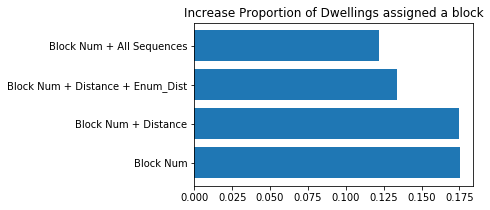

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.barh(['Block Num', 'Block Num + Distance', 'Block Num + Distance + Enum_Dist', 'Block Num + All Sequences'], num_assigned_dwelling)
# ax.scatter(num_between, num_assigned_dwelling)
ax.set_title("Increase Proportion of Dwellings assigned a block")

## Take a look at where they differ

In [20]:
(all_dwellings_1[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1)).sum()

9

In [27]:
## sample of where they are different
all_dwellings_2[[ward_col, 'dwelling_id', block_col, 'sequence_id']].iloc[4685:4695]

,CENSUS_WARD_NUM,dwelling_id,CD_BLOCK_NUM,sequence_id
4685,5,996,mn1850_05_74.0096_40.7210,4688.0
4686,5,997,NaN,NaN
4687,5,998,NaN,NaN
4688,5,999,mn1850_05_74.0093_40.7203,4688.0
4689,5,1000,mn1850_05_74.0062_40.7210,4690.0
4690,5,1001,mn1850_05_74.0072_40.7222,4690.0
4691,5,1002,NaN,NaN
4692,5,1003,mn1850_05_74.0072_40.7222,4694.0
4693,5,1004,mn1850_05_74.0087_40.7216,4694.0
4694,5,1005,mn1850_05_74.0094_40.7217,4694.0


In [40]:
(all_dwellings_3[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1)).sum()

682

# 2. Distance Threshold for distance sequence
# 3. In Between Num dwelling

In [41]:
distance_threshold = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
in_between_num_list = num_between = [5,10,15, 20, 25,40, None]
result_inbetween_distthreshold = {}
for in_between_num in in_between_num_list:
    result_list = []
    for max_dist in distance_threshold:

        census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                         fixed = True, distance = True, d = max_dist)

        census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
        dwellings_sequence = census_all_dwellings.dropna(subset=[block_col])

        ## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
        ## dwellings_sequence => known dwellings
        dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)

        """
        2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
        `num_between_real` are included in df of all known dwellings.
        """
        dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                                block_col+'_next', 
                                                                                              'num_between_real',
                                                                                              'header']], 
                                                                     on=[ward_col, dwelling_col], how='left')

        all_dwellings = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                               block_col = block_col, fill_column = block_col,
                                                               check_column = [block_col, 'sequence_id'], ward_col = ward_col, 
                                                                 dwelling_col = dwelling_col, dwelling_max = in_between_num)

        ##interpolated portion
        total_assigned_dwellings = all_dwellings.loc[~all_dwellings[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups
        result_list.append(round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5))

        print("Maximum of {} miles between each dwelling in a sequence".format(str(max_dist)))
        print("Maximum of {} dwellings in between".format(str(in_between_num)))
        print("Number of dwellings that would be assigned a block:", total_assigned_dwellings - known_num_dwellings)
        print("Proportion increase dwellings assigned a block:", round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5), "\n")

        result_inbetween_distthreshold[in_between_num] = result_list

d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2


d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d

d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
Maximum of 0.3 miles between each dwelling in a sequence
Maximum of 5 dwellings in between
Number of dwe

d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
Maximum of 0.35 miles between each dwelling in a sequence
Maximum of 5 dwellings in between
Number of dwellings that would be assigned a block: 2283
Proportion increase dwellings assigned a block: 0.13669 

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0

d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2


d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
Maximum of 0.25 miles between each dwelling in a sequence
Maximum of 10 dwellings 

d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4


d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
Maximum of 0.2 miles between each dwelling in a sequence
Maximum of 15 dwellings in between
Number of dwellings that would be assigned a block: 2709
Proportion increase dwellings assigned a block: 0.1622 

d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25


d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3


d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4


d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
Maximum of 0.15 miles between each dwelling in a sequence
Maximum of 20 dwellings in between
Number of dwellings that would be assigned a block: 2728
Proportion increase dwellings assigned a block: 0.16333 

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0

d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3


d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4


d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
Maximum of 0.1 miles between each dwelling in a sequence
Maximum of 25 dwellings in between
Number of dwellings that would be assigned a block: 2741
Proportion increase dwellings assigned a block: 0.16411 

d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.1

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2


d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d

d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3


d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4


d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
Maximum of 0.05 miles between each dwelling in a sequence
Maximum of 40 dwellings in between
Number of dwellings that would be assigned a block: 2590
Proportion increase dwellings assigned a block: 0.15507 

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:

d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2


d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d

d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3


d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

Maximum of 0.4 miles between each dwelling in a sequence
Maximum of 40 dwellings in between
Number of dwellings that would be assigned a block: 2810
Proportion increase dwellings assigned a block: 0.16824 

d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2


d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d

d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3


d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
Maximum of 0.35 miles between each dwelling in a sequence
Maximum of None dwellings in between
Number of dwellings that would be assigned a block: 2930
Proportion increase dwellings assigned a block: 0.17543 

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:

In [44]:
summ = pd.DataFrame(result_inbetween_distthreshold) ##row: distance threshold, col: in between num
summ

,5,10,15,20,25,40,NaN
0,0.13016,0.14926,0.15088,0.15202,0.15333,0.15507,0.16226
1,0.13657,0.15866,0.16166,0.16279,0.16411,0.16770,0.17489
2,0.13669,0.15920,0.16220,0.16333,0.16465,0.16824,0.17543
3,0.13669,0.15920,0.16220,0.16333,0.16465,0.16824,0.17543
4,0.13669,0.15920,0.16220,0.16333,0.16465,0.16824,0.17543
5,0.13669,0.15920,0.16220,0.16333,0.16465,0.16824,0.17543
6,0.13669,0.15920,0.16220,0.16333,0.16465,0.16824,0.17543
7,0.13669,0.15920,0.16220,0.16333,0.16465,0.16824,0.17543


* **Distance Threshold does not impact the block number interpolation**. (Same values along a column)

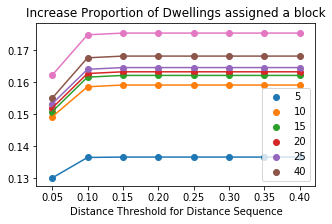

In [46]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
for c in summ.columns:
    ax.plot(distance_threshold, summ[c])
    ax.scatter(distance_threshold, summ[c], label=c)
    ax.set_title("Increase Proportion of Dwellings assigned a block")
    ax.set_xlabel('Distance Threshold for Distance Sequence')
ax.legend()

\* **Pink is without distance threshold**

* The distance threshold does not matter once it is greater than 0.05
* The less restrictive about num in between, the more interpolation proportion